In [1]:
!nvidia-smi

Mon Jul  7 13:14:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
%pip install "ultralytics<=8.3.40" supervision roboflow
# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 42.0/112.6 GB disk)


In [4]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="***************")
project = rf.workspace("autoiq").project("license-plate-recognition-rxg4e-zea9o")
version = project.version(2)
dataset = version.download("yolov11")


/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to License-Plate-Recognition-2 in yolov11:: 100%|██████████| 20262/20262 [00:03<00:00, 6299.59it/s]


## Custom Training

In [5]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 331MB/s]
New https://pypi.org/project/ultralytics/8.3.162 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/License-Plate-Recognition-2/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nm

In [6]:
!ls {HOME}/runs/detect/train/

args.yaml					    results.png
confusion_matrix_normalized.png			    train_batch0.jpg
confusion_matrix.png				    train_batch1.jpg
events.out.tfevents.1751894578.7364009926dc.3085.0  train_batch2.jpg
F1_curve.png					    val_batch0_labels.jpg
labels_correlogram.jpg				    val_batch0_pred.jpg
labels.jpg					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


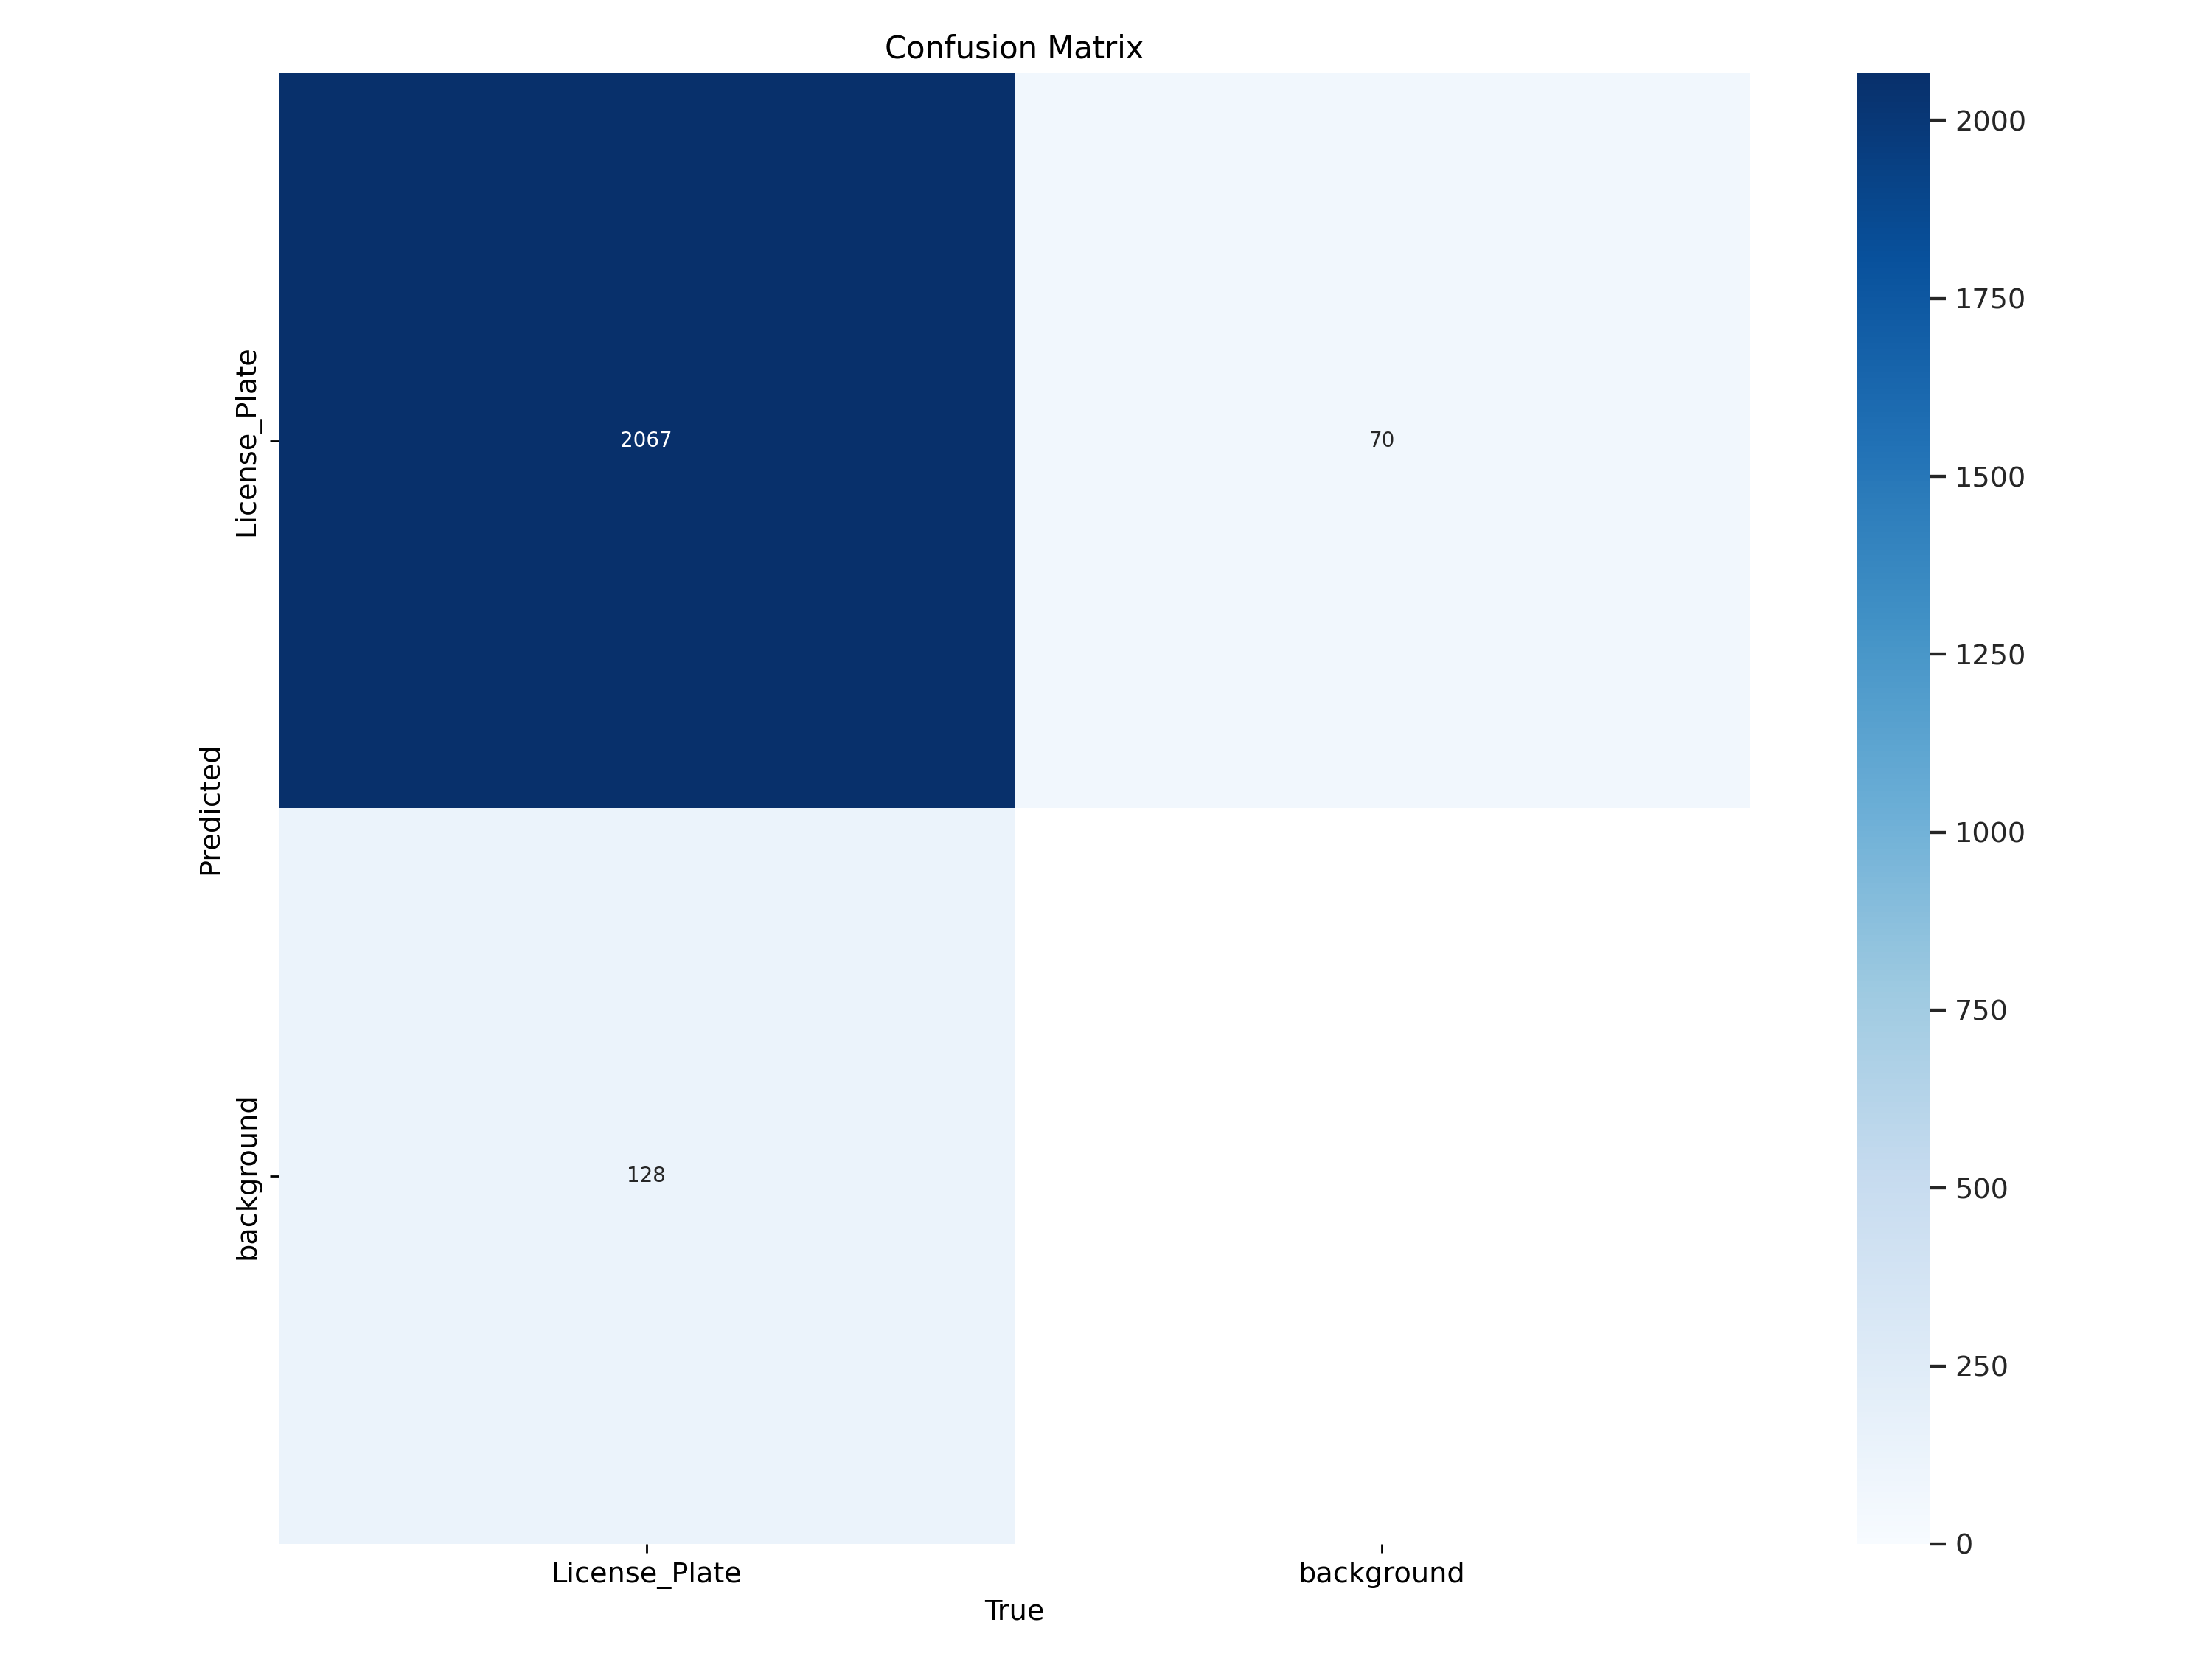

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

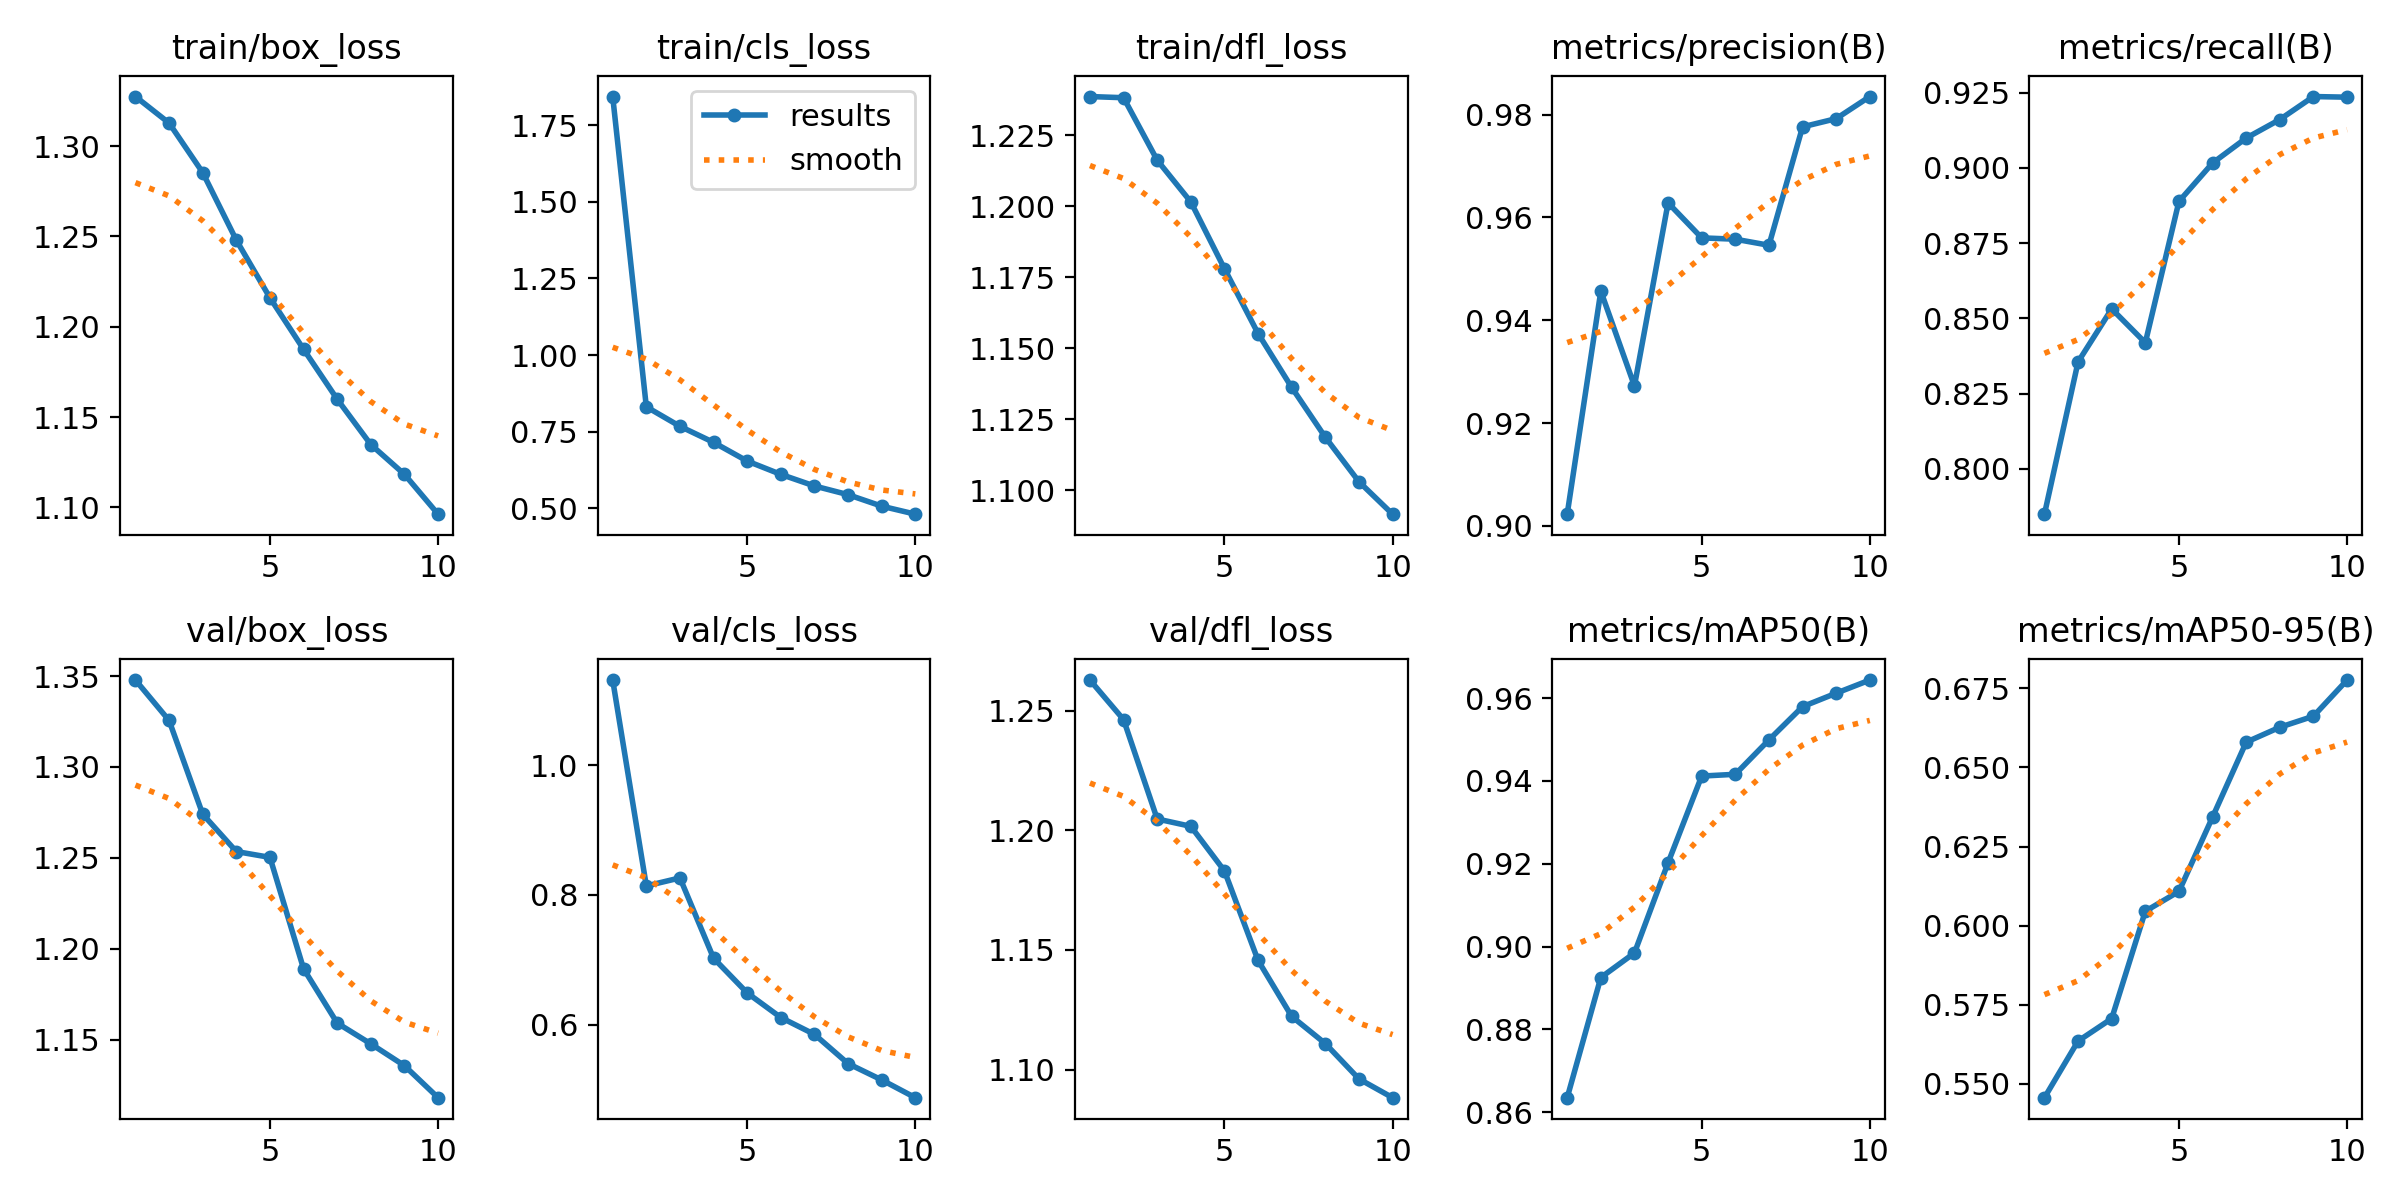

In [8]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

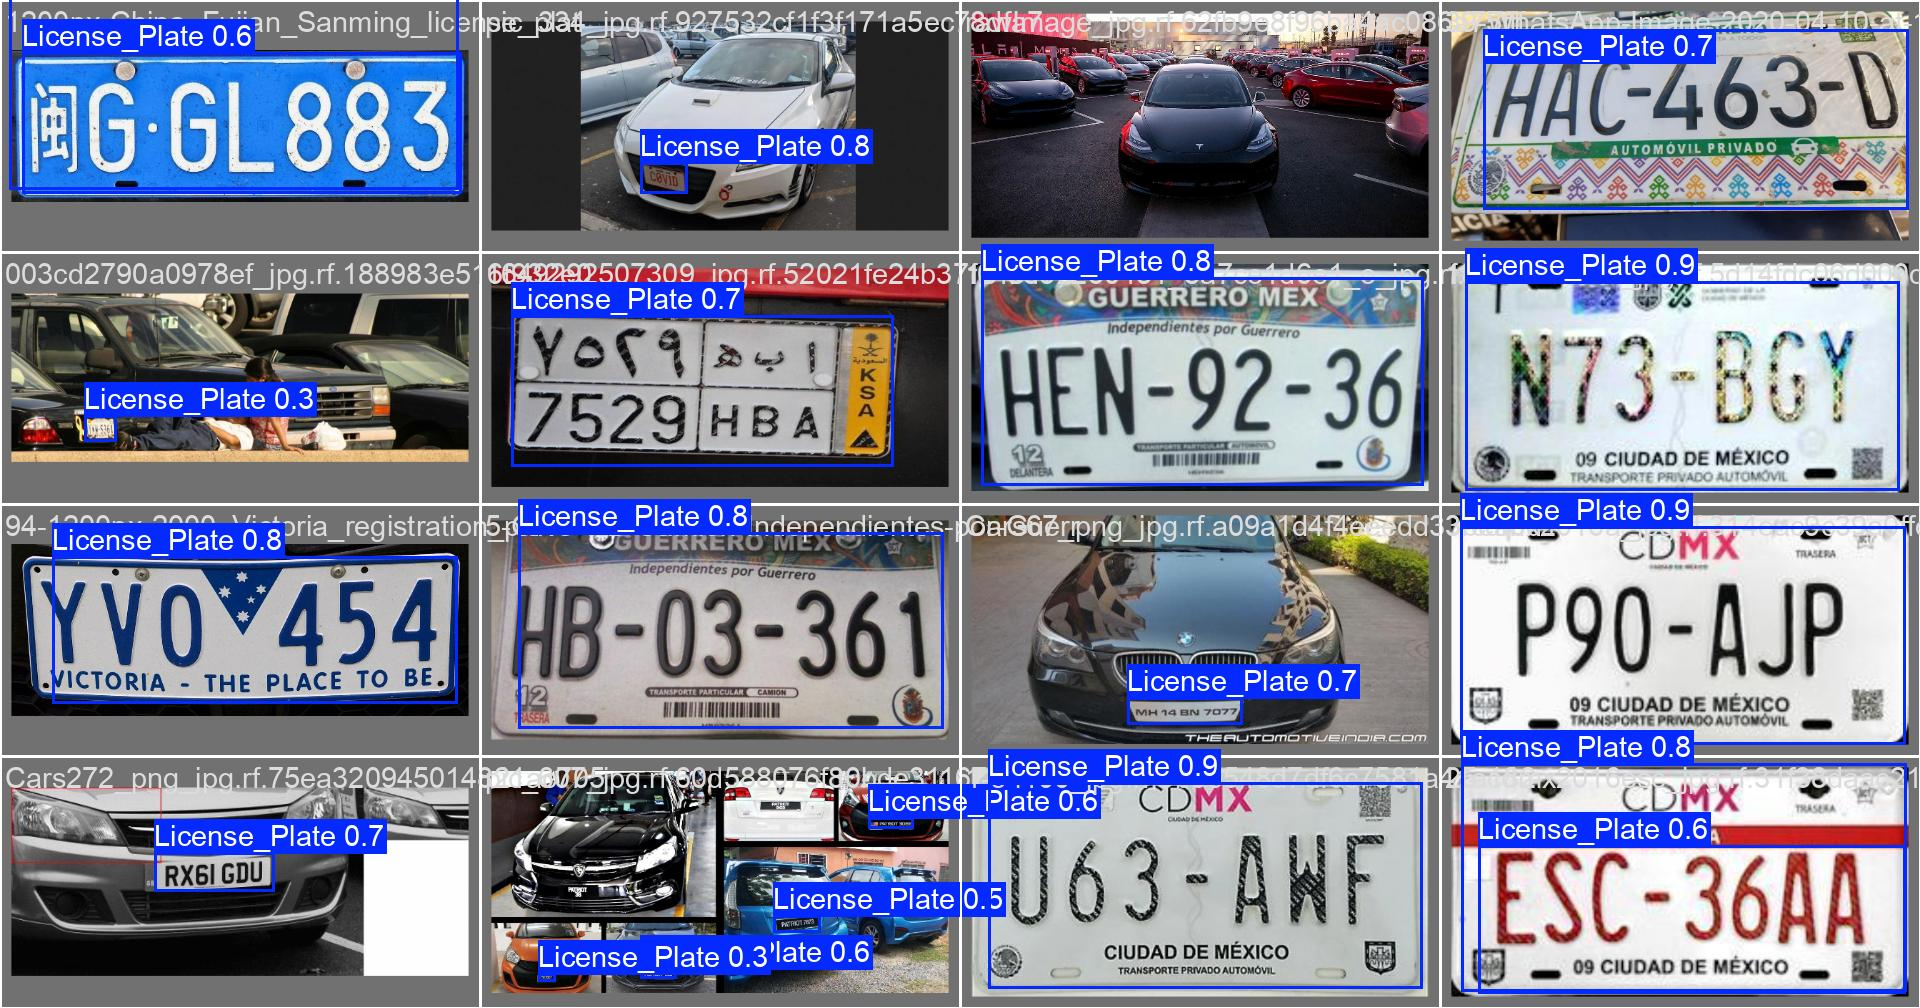

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [10]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/datasets/License-Plate-Recognition-2/valid/labels.cache... 2048 images, 3 backgrounds, 0 corrupt: 100% 2048/2048 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 128/128 [00:22<00:00,  5.75it/s]
                   all       2048       2195      0.983      0.924      0.965      0.678
Speed: 0.2ms preprocess, 6.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [13]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

View the status of your deployment at: https://app.roboflow.com/autoiq/license-plate-recognition-rxg4e-zea9o/2
Share your model with the world at: https://universe.roboflow.com/autoiq/license-plate-recognition-rxg4e-zea9o/model/2
